In [8]:
import sqlite3
import pandas as pd

conn = sqlite3.connect(':memory:')
cursor = conn.cursor()
print("Database connected.")

# load csv files
fertility_rate = pd.read_csv("../data/1_Adolescent fertility rate (births per 1,000 women ages 15-19).csv", skiprows=4)
population_growth = pd.read_csv("../data/1_Population growth (annual %).csv", skiprows=4)
metadata = pd.read_csv("../data/metadata.csv", skiprows=4)

fertility_rate.to_sql("fertility_rate", conn, if_exists="replace", index=False)
population_growth.to_sql("population_growth", conn, if_exists="replace", index=False)
metadata.to_sql("metadata", conn, if_exists="replace", index=False)

Database connected.


261

In [2]:
query1 = """
SELECT AVG(change) AS average_fertility_rate_change
FROM (SELECT "Country Name", "1960", "2023", "2023"-"1960" AS change
FROM fertility_rate)
"""

display(pd.read_sql(query1, conn))

,average_fertility_rate_change
0,-58.333256


In [3]:
query2 = """
SELECT AVG(change) AS average_population_growth_change
FROM (SELECT "Country Name", "1961", "2023", "2023"-"1961" AS change
FROM population_growth)
"""

display(pd.read_sql(query2, conn))

,average_population_growth_change
0,-1.103123


In [9]:
query = """
CREATE TABLE fertility_vs_population_change AS
SELECT fertility_rate."Country Name", metadata.AFW AS code, metadata."Unnamed: 1" AS region, metadata."Unnamed: 2" AS income, (fertility_rate."2023"-fertility_rate."1960") AS fertility_rate_change,(population_growth."2023"-population_growth."1961") AS population_growth_change
FROM fertility_rate
LEFT JOIN metadata ON fertility_rate."Country Code" = metadata.AFW
LEFT JOIN population_growth ON fertility_rate."Country Name" = population_growth."Country Name"
WHERE "Unnamed: 1" IS NOT NULL AND "fertility_rate_change" IS NOT NULL AND "population_growth_change" IS NOT NULL
"""

cursor.execute(query)
conn.commit()

In [10]:
query3 = """
SELECT *
FROM fertility_vs_population_change
"""

display(pd.read_sql(query3, conn))

,Country Name,code,region,income,fertility_rate_change,population_growth_change
0,Angola,AGO,Sub-Saharan Africa,Lower middle income,48.292,1.752858
1,Albania,ALB,Europe & Central Asia,Upper middle income,-49.317,-4.269273
2,Andorra,AND,Europe & Central Asia,High income,-5.830,-6.381069
3,United Arab Emirates,ARE,Middle East & North Africa,High income,-152.040,-0.965857
4,Argentina,ARG,Latin America & Caribbean,Upper middle income,-30.742,-1.368191
...,...,...,...,...,...,...
208,Kosovo,XKX,Europe & Central Asia,Upper middle income,-59.963,-3.328263
209,"Yemen, Rep.",YEM,Middle East & North Africa,Low income,-69.409,0.812077
210,South Africa,ZAF,Sub-Saharan Africa,Upper middle income,-24.830,-1.478009
211,Zambia,ZMB,Sub-Saharan Africa,Lower middle income,-63.325,-0.338520


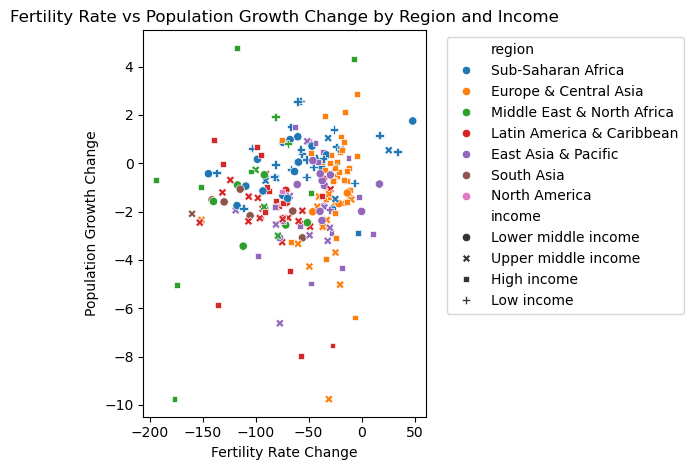

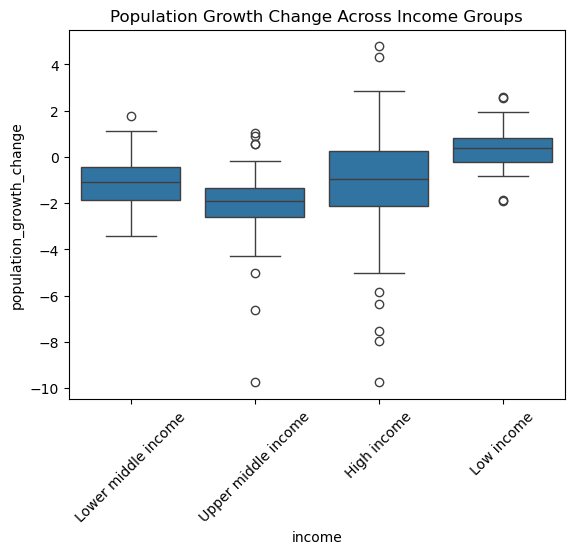

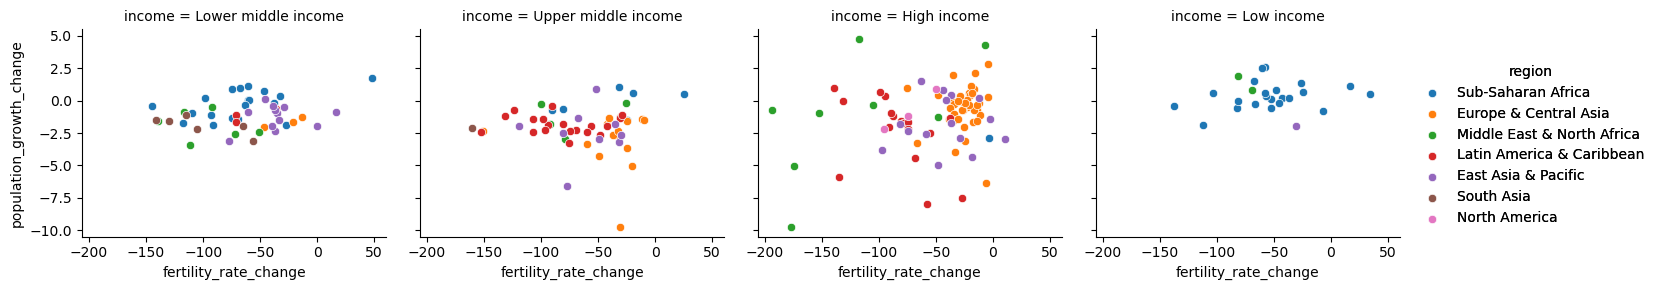

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_sql('SELECT * FROM fertility_vs_population_change', conn)

sns.scatterplot(data=df, x='fertility_rate_change', y='population_growth_change', hue='region', style='income')
plt.title('Fertility Rate vs Population Growth Change by Region and Income')
plt.xlabel('Fertility Rate Change')
plt.ylabel('Population Growth Change')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('../figures/1scatter.png', bbox_inches='tight')
plt.show()

sns.boxplot(data=df, x='income', y='population_growth_change')
plt.title('Population Growth Change Across Income Groups')
plt.xticks(rotation=45)
plt.savefig('../figures/1population_across_income.png', bbox_inches='tight')
plt.show()

g = sns.FacetGrid(df, col='income', hue='region')
g.map(sns.scatterplot, 'fertility_rate_change', 'population_growth_change')
g.add_legend()
plt.savefig('../figures/1faceted.png', bbox_inches='tight')
g.add_legend()